In [36]:
# Install the requiered packages to run MLFlow

!pip install mlflow --quiet
!pip install pyngrok --quiet

In [37]:
import mlflow
import mlflow.pytorch
import warnings
from pyngrok import ngrok
from getpass import getpass

In [38]:
warnings.filterwarnings("ignore")

# Start MLflow UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Autologging features
mlflow.pytorch.autolog()

# Ensure no existing ngrok tunnels are running
ngrok.kill()

In [39]:
# Setup ngrok auth token (use environment variables or secure input methods in production)
NGROK_AUTH_TOKEN = getpass('Enter your ngrok auth token:')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPS tunnel to the MLflow UI running on port 5000
try:
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)
except Exception as e:
    print("Failed to start ngrok tunnel:", e)

/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


Enter your ngrok auth token: ·················································


MLflow Tracking UI: https://cf32-34-70-168-113.ngrok-free.app


[2024-04-26 14:26:24 +0000] [658] [INFO] Starting gunicorn 21.2.0
[2024-04-26 14:26:24 +0000] [658] [INFO] Listening at: http://127.0.0.1:5000 (658)
[2024-04-26 14:26:24 +0000] [658] [INFO] Using worker: sync
[2024-04-26 14:26:24 +0000] [659] [INFO] Booting worker with pid: 659
[2024-04-26 14:26:24 +0000] [660] [INFO] Booting worker with pid: 660
[2024-04-26 14:26:24 +0000] [661] [INFO] Booting worker with pid: 661
[2024-04-26 14:26:24 +0000] [662] [INFO] Booting worker with pid: 662


In [5]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the CSV data
metadata = pd.read_csv('/kaggle/input/train-data/train.csv')

# Basic CSV EDA
print(metadata.head())
print(metadata.describe())
print(metadata.isnull().sum())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
            site_id    patient_id      image_id           age        cancer  \
count  5

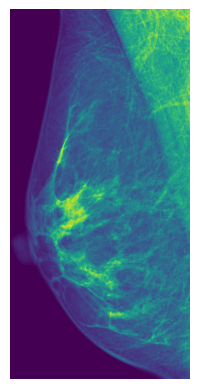

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image = mpimg.imread('/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10011_1031443799.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [7]:
def create_image_path(row, base_path='/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut'):
    image_id = str(int(row['image_id']))
    patient_id = str(int(row['patient_id']))
    return f"{base_path}/{patient_id}_{image_id}.png"

metadata['image_path'] = metadata.apply(create_image_path, axis=1)

In [8]:
cancer_counts=metadata.groupby('cancer').size()
# Print the result
print(cancer_counts)

cancer
0    53548
1     1158
dtype: int64


In [9]:
import pandas as pd

# Convert patient_id to string if it's not already, to prevent any loss of leading zeros
metadata['patient_id'] = metadata['patient_id'].astype(str)

# Group by 'patient_id' and filter out those groups which don't have exactly four images
valid_groups = metadata.groupby('patient_id').filter(lambda x: len(x) == 4)

# Now we create a dictionary that has patient IDs as keys and the list of image paths as values
patient_image_groups = valid_groups.groupby('patient_id')['image_path'].apply(list).to_dict()

# Display the patient IDs and their corresponding image paths for the first two patients
for patient_id in list(patient_image_groups)[:2]:
    print(f"Patient ID: {patient_id}")
    print(f"Image Paths: {patient_image_groups[patient_id]}\n")


Patient ID: 10006
Image Paths: ['/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10006_462822612.png', '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10006_1459541791.png', '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10006_1864590858.png', '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10006_1874946579.png']

Patient ID: 10011
Image Paths: ['/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10011_220375232.png', '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10011_270344397.png', '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10011_541722628.png', '/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/10011_1031443799.png']



In [10]:
import pandas as pd

# Convert patient_id to string if it's not already, to prevent any loss of leading zeros
metadata['patient_id'] = metadata['patient_id'].astype(str)

# Group by 'patient_id' and filter out those groups which don't have exactly four images
valid_groups = metadata.groupby('patient_id').filter(lambda x: len(x) == 4)

# Now we create a dictionary that has patient IDs as keys and the unique label as values
patient_cancer_groups = valid_groups.groupby('patient_id')['cancer'].first().to_dict()

# Display the patient IDs and their corresponding label for the first two patients
for patient_id in list(patient_cancer_groups)[:2]:
    print(f"Patient ID: {patient_id}")
    print(f"Label: {patient_cancer_groups[patient_id]}\n")


Patient ID: 10006
Label: 0

Patient ID: 10011
Label: 0



In [11]:
# Initialize a counter dictionary
count = {0: 0, 1: 0}

# Iterate over each patient's cancer group and increment the counter
for group in patient_cancer_groups.values():
    count[group] += 1

# Display the count of 0s and 1s
count

{0: 8082, 1: 151}

In [12]:
dataset = []

for patient_id, images in patient_image_groups.items():
    label = patient_cancer_groups.get(patient_id, None)  # Get the label for the current patient_id
    if label is not None:  # Check if label exists
        entry = {'patient_id': patient_id, 'images': images, 'label': label}
        dataset.append(entry)

### **DATASET_1 (Weighted Data)**

In [13]:
# First, we need to separate the records with label 0 and label 1
label_0_group = [record for record in dataset if record['label'] == 0]
label_1_group = [record for record in dataset if record['label'] == 1]

# Assuming label 1 group has the minimum count, we fix the number of 0's to match the number of 1's
fixed_label_0_group = label_0_group[:len(label_1_group)]

# Combine the fixed number of 0's with all the 1's to create a balanced dataset
balanced_dataset = fixed_label_0_group + label_1_group

### **DATASET_2 (0_850, 1_151)**

In [60]:
# Specify the number of samples you want from label 0
number_of_samples = 850

# Check if there are enough samples in label 0 group, if not use all available
if len(label_0_group) >= number_of_samples:
    selected_label_0_samples = label_0_group[:number_of_samples]
else:
    selected_label_0_samples = label_0_group

# Combine the selected samples from label 0 with all samples from label 1
balanced_dataset_2 = selected_label_0_samples + label_1_group

In [14]:
# Display the balanced dataset
len(balanced_dataset)

302

In [15]:
# Assuming patient_image_groups is your dictionary
number_of_patients = len(patient_image_groups)
print("Number of patients with exactly four images:", number_of_patients)

Number of patients with exactly four images: 8233


In [70]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
import random
import datetime
import os
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

In [44]:
# Define an ImageDataGenerator with augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the images by up to 20 degrees
    width_shift_range=0.2,   # Shift the image width by a maximum of 20%
    height_shift_range=0.2,  # Shift the image height by a maximum of 20%
    shear_range=0.15,        # Shear the image by up to 15%
    zoom_range=0.2,          # Zoom in on the image by up to 20%
    channel_shift_range=10,  # Change the color channels by up to a value of 10
    horizontal_flip=True,    # Allow horizontal flipping of the image
    fill_mode='nearest',     # Use the nearest fill mode for new pixels
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Apply VGG16 preprocessing
)

# For validation data, no augmentation is applied, just rescaling and preprocessing
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [45]:
# Function to split dataset into training and validation sets
def split_dataset(dataset, train_size=0.8):
    """Splits the dataset into training and validation sets.
    
    Args:
        dataset (list): The complete dataset list of dictionaries.
        train_size (float): The proportion of the dataset to include in the train split.
    
    Returns:
        tuple: Two lists, (training_dataset, validation_dataset).
    """
    # Shuffle dataset to ensure random distribution
    np.random.shuffle(dataset)
    
    # Calculate the number of samples in the training set
    train_end = int(len(dataset) * train_size)
    
    # Split the dataset
    training_dataset = dataset[:train_end]
    validation_dataset = dataset[train_end:]
    
    return training_dataset, validation_dataset

# Split your dataset
training_data, validation_data = split_dataset(balanced_dataset)

In [46]:
import tensorflow as tf

def generate_data(dataset, datagen, batch_size=10, augment=False):
    while True:
        for start in range(0, len(dataset), batch_size):
            end = min(start + batch_size, len(dataset))
            batch_data = dataset[start:end]
            
            # Initialize lists for images and labels
            batch_images = [[] for _ in range(4)]  # Create a list of lists for each input
            batch_labels = []
            
            for entry in batch_data:
                # Process images and add them to the corresponding list
                for i, img_path in enumerate(entry['images']):
                    img = load_img(img_path, target_size=(224, 224))
                    img = img_to_array(img)
                    if augment:
                        img = datagen.random_transform(img)
                    img = preprocess_input(img)
                    batch_images[i].append(img)

                # Add the label
                batch_labels.append(entry['label'])
            
            # Convert lists of images and labels to tensors
            batch_images = [np.stack(images) for images in batch_images]  # Stack images for each input
            batch_labels = np.array(batch_labels)

            # Convert to tensors
            batch_images = [tf.convert_to_tensor(images, dtype=tf.float32) for images in batch_images]
            batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.float32)
            
            # Yield the batch in the correct structure
            yield tuple(batch_images), batch_labels     

### **Train_Dataset_1**

In [47]:
# Create a `tf.data.Dataset` from the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: generate_data(training_data, train_datagen, batch_size=10, augment=True),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Similarly for the validation dataset
validation_dataset = tf.data.Dataset.from_generator(
    lambda: generate_data(validation_data, validation_datagen, batch_size=10, augment=False),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

### **Train_Dataset_2**

In [61]:
training_data_2, validation_data_2 = split_dataset(balanced_dataset_2)

# Create a `tf.data.Dataset` from the generator
train_dataset_2 = tf.data.Dataset.from_generator(
    lambda: generate_data(training_data_2, train_datagen, batch_size=10, augment=True),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

# Similarly for the validation dataset
validation_dataset_2 = tf.data.Dataset.from_generator(
    lambda: generate_data(validation_data_2, validation_datagen, batch_size=10, augment=False),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

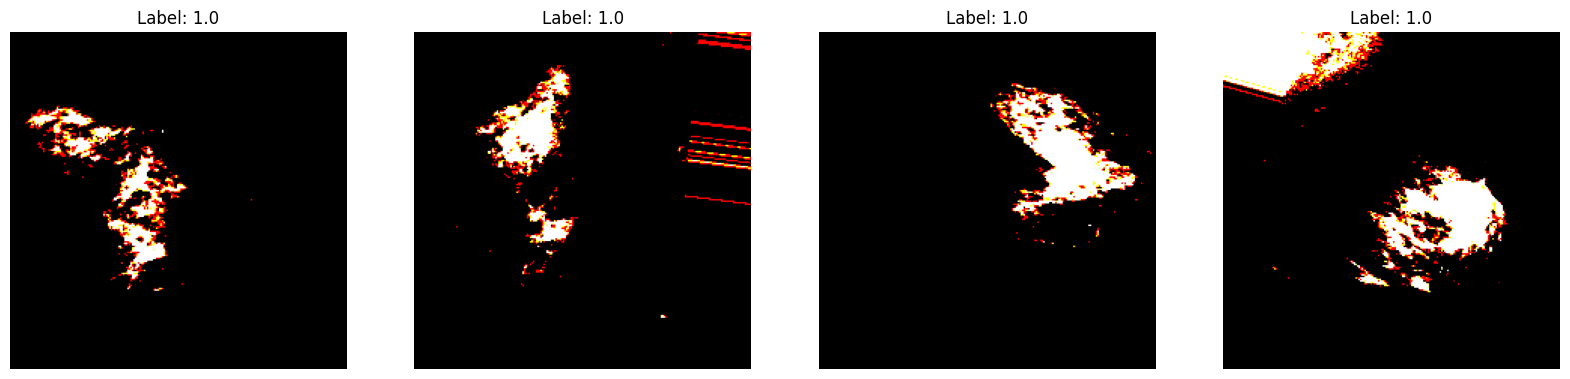

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, n_images=4):
    """Plot a sample of images with labels."""
    fig, axes = plt.subplots(1, n_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        # Assuming images are in the format (batch, height, width, channels)
        ax.imshow(np.clip(images[i][0], 0, 1))  # Take the first image of each batch and clip values between 0 and 1
        ax.title.set_text(f'Label: {labels[0]}')
        ax.axis('off')
    plt.show()

# Fetch a single batch from the training dataset
for image_batch, label_batch in train_dataset.take(1):
    # Prepare images for display
    images = [image_batch[i].numpy() for i in range(4)]  # Extract each image set from the tuple
    labels = label_batch.numpy()
    
    # Use the plotting function
    plot_images(images, labels)

In [49]:
# Set seeds to make the random work deterministic
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# Load VGG16 as the base model
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Create four input layers, one for each image
input_1 = Input(shape=(224, 224, 3))
input_2 = Input(shape=(224, 224, 3))
input_3 = Input(shape=(224, 224, 3))
input_4 = Input(shape=(224, 224, 3))

# Extract features from each input using the shared base model
features_1 = base_model(input_1)
features_2 = base_model(input_2)
features_3 = base_model(input_3)
features_4 = base_model(input_4)

# Flatten the features
flattened_features_1 = Flatten()(features_1)
flattened_features_2 = Flatten()(features_2)
flattened_features_3 = Flatten()(features_3)
flattened_features_4 = Flatten()(features_4)

# Concatenate the flattened features
concatenated = concatenate([flattened_features_1, flattened_features_2, flattened_features_3, flattened_features_4])

# Add a dense layer for classification
classification_layer = Dense(256, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(classification_layer)  # Use 'sigmoid' for binary classification

# Create the model
model_1 = Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model_1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_11[0… │
│                     │                   │            │ input_layer_12[0… │
│                     │                   │            │ input_layer_13[0… │
│                     │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 25088)     │          0 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 25088)     │          0 │ vgg16[2][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 25088)     │          0 │ vgg16[3][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100352)    │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0],  │
│                     │                   │            │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │ 25,690,368 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,786,565 (350.14 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 51,381,252 (196.00 MB)

In [58]:
with open('model_1_summary.txt', 'w') as fh:
    model_1.summary(print_fn=lambda x: fh.write(x + '\n'))

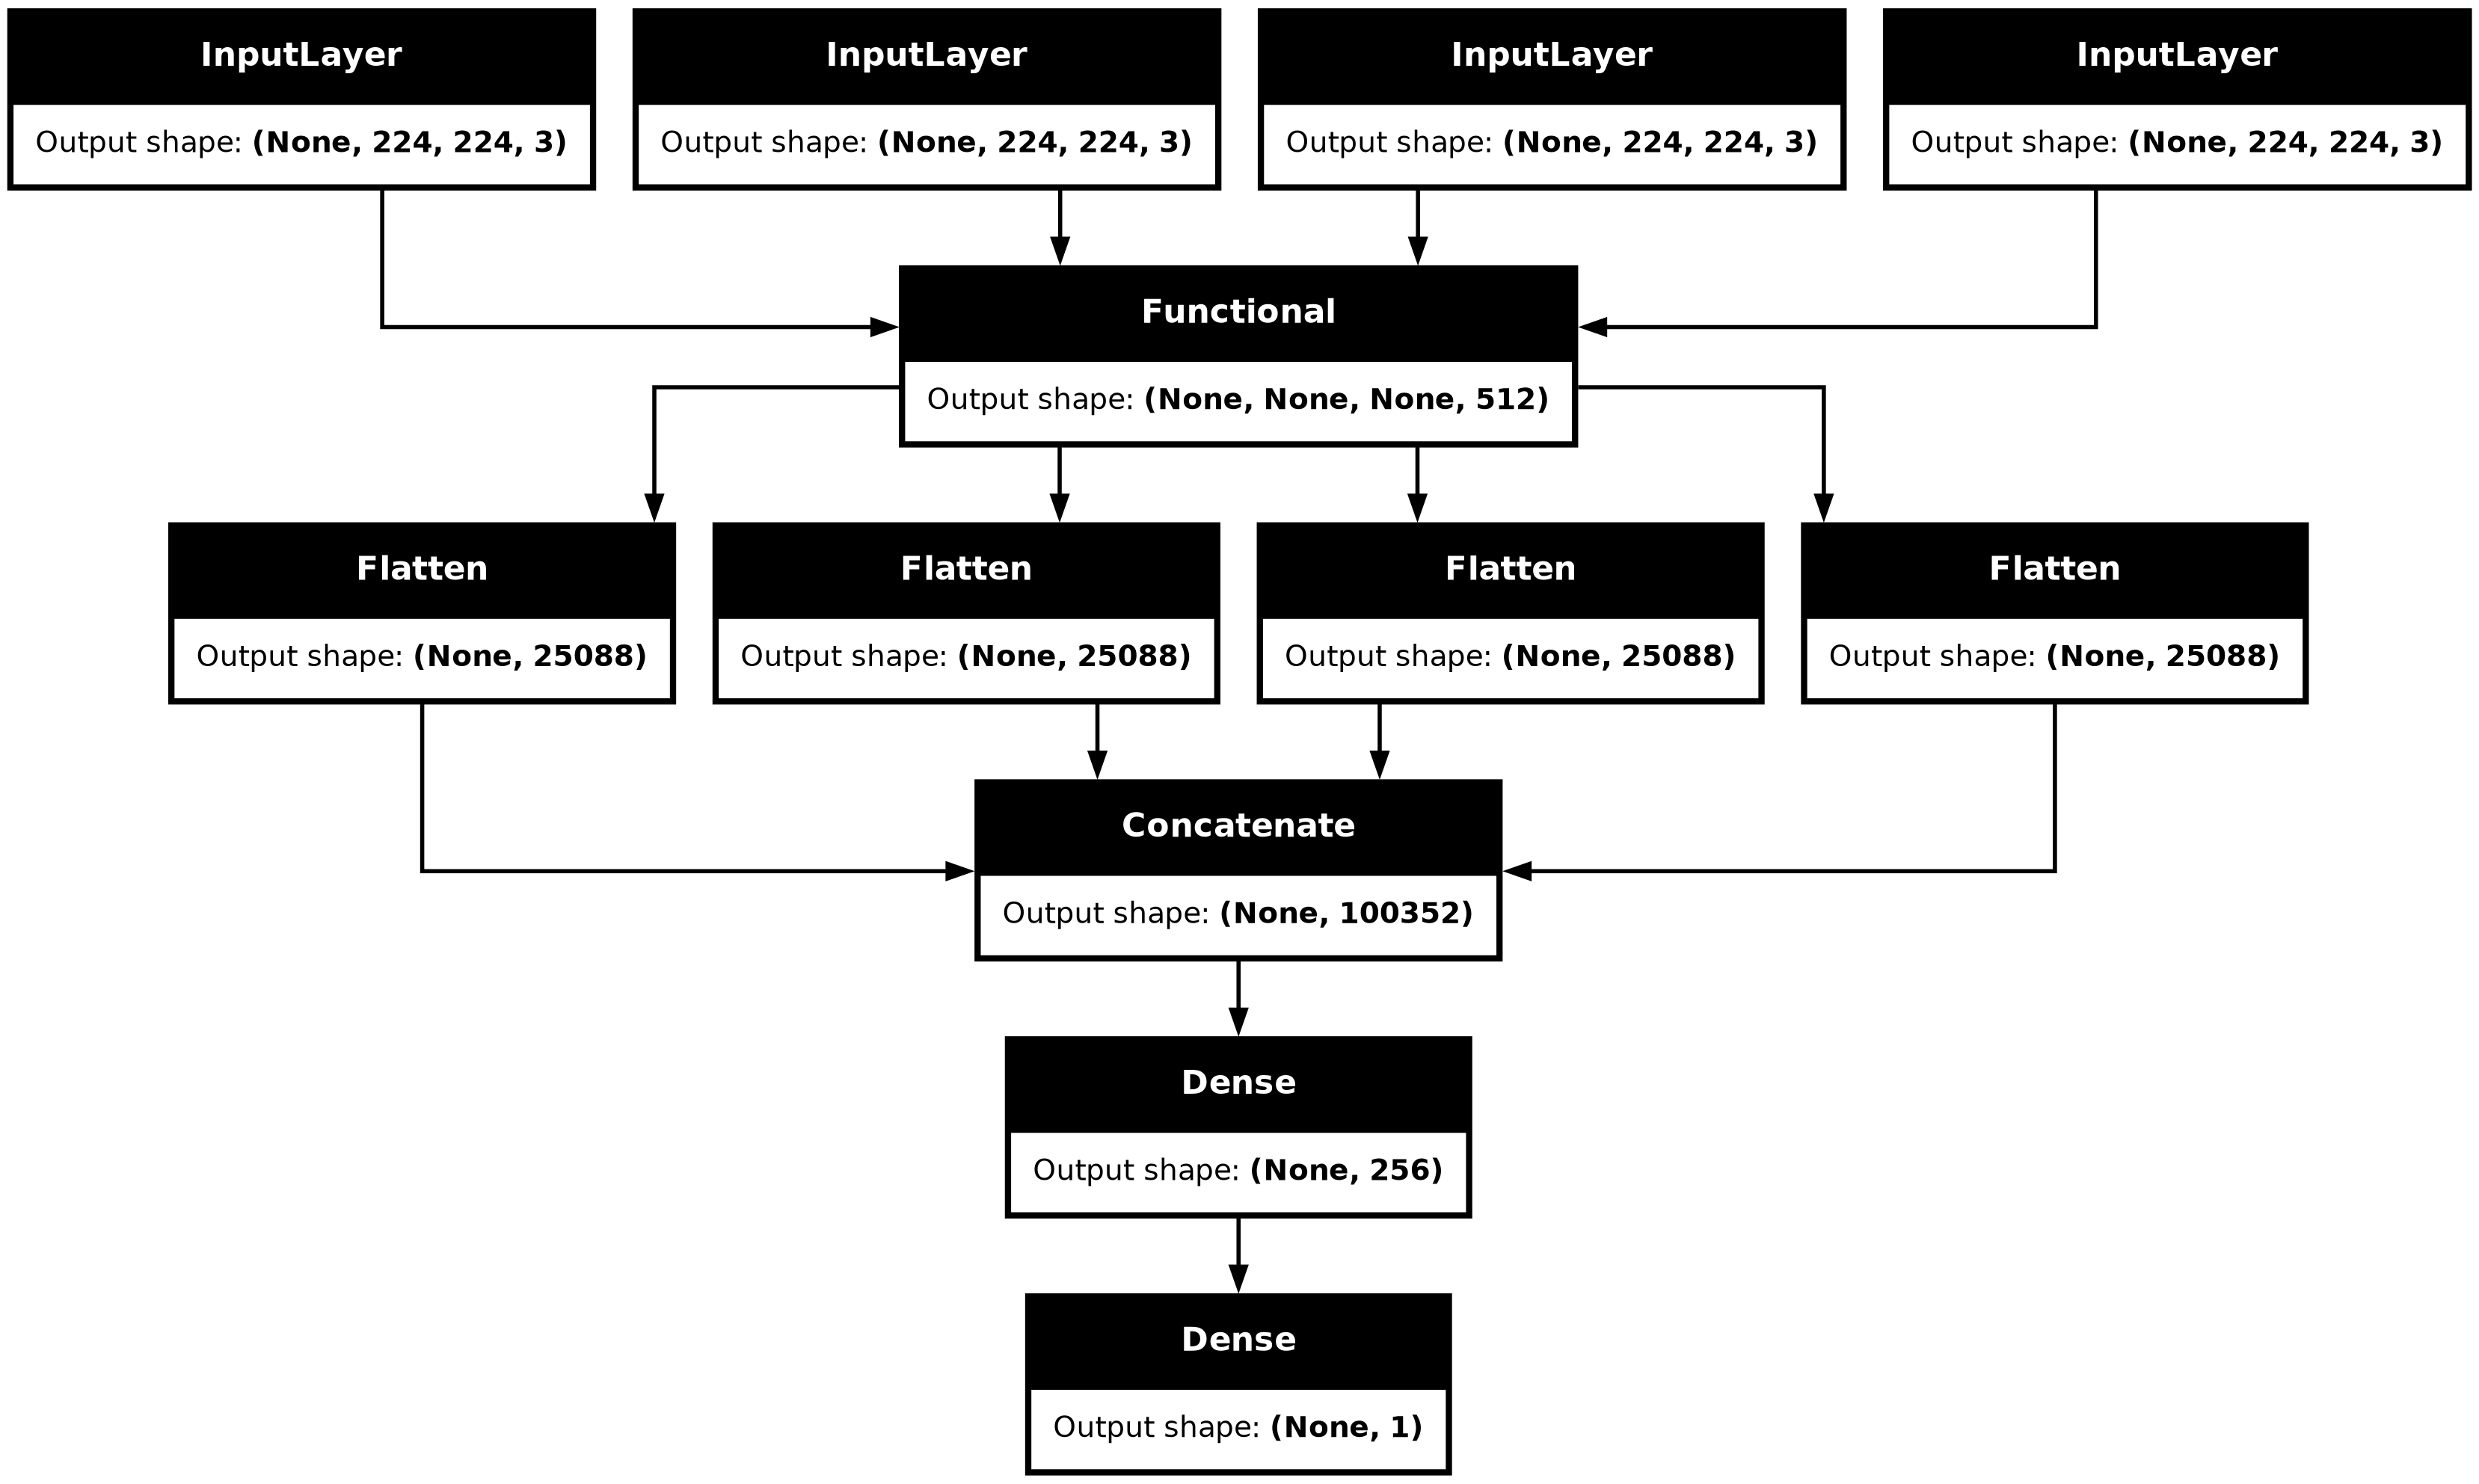

In [56]:
tf.keras.utils.plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [65]:
batch_size = 10

total_training_samples = len(training_data)
total_validation_samples = len(validation_data)

# Instead of using len(dataset), define steps_per_epoch and validation_steps directly
steps_per_epoch = total_training_samples // batch_size
validation_steps = total_validation_samples // batch_size

total_training_samples_2 = len(training_data_2)
total_validation_samples_2 = len(validation_data_2)

# Instead of using len(dataset), define steps_per_epoch and validation_steps directly
steps_per_epoch_2 = total_training_samples_2 // batch_size
validation_steps_2 = total_validation_samples_2 // batch_size

In [51]:
# model.fit(
#     train_dataset,
#     steps_per_epoch=steps_per_epoch,
#     epochs=5,
#     validation_data=validation_dataset,
#     validation_steps=validation_steps
# )

In [54]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts
from keras.callbacks import Callback

# Set the MLflow tracking URI to the ngrok URL
mlflow.set_tracking_uri('https://cf32-34-70-168-113.ngrok-free.app')

In [55]:
# Start a new run with a specific name
with mlflow.start_run(run_name="VGG16") as run:

    # Log parameters (e.g., number of layers, optimizer)
    log_param("Number of layers", len(base_model.layers))
    log_param("Optimizer", 'adam')
    log_param("Loss function", 'binary_crossentropy')

    # Custom callback to log metrics at the end of each epoch
    class MLFlowCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            for key, value in logs.items():
                if key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
                    log_metric(key, value, step=epoch)

    # Fit the model with the MLFlow callback to log metrics after each epoch
    history = model_1.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=5,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        callbacks=[MLFlowCallback()]
    )

    # Log the model
    mlflow.keras.log_model(model_1, "model")

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4742 - loss: 69.9543 - val_accuracy: 0.4000 - val_loss: 14.4058
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5363 - loss: 19.5915 - val_accuracy: 0.4314 - val_loss: 13.6035
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5730 - loss: 11.5477 - val_accuracy: 0.4706 - val_loss: 18.1109
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5843 - loss: 13.8127 - val_accuracy: 0.4510 - val_loss: 12.4572
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6037 - loss: 8.7497 - val_accuracy: 0.5098 - val_loss: 10.5499


2024/04/26 14:33:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
[2024-04-26 14:34:15 +0000] [658] [CRITICAL] WORKER TIMEOUT (pid:662)
[2024-04-26 14:34:15 +0000] [662] [INFO] Worker exiting (pid: 662)
[2024-04-26 14:34:15 +0000] [658] [ERROR] Worker (pid:662) exited with code 1
[2024-04-26 14:34:15 +0000] [658] [ERROR] Worker (pid:662) exited with code 1.
[2024-04-26 14:34:15 +0000] [810] [INFO] Booting worker with pid: 810
[2024-04-26 14:34:46 +0000] [658] [CRITICAL] WORKER TIMEOUT (pid:659)
[2024-04-26 14:34:46 +0000] [659] [INFO] Worker exiting (pid: 659)
[2024-04-26 14:34:46 +0000] [658] [ERROR] Worker (pid:659) exited with code 1
[2024-04-26 14:34:46 +0000] [658] [ERROR] Worker (pid:659) exited with code 1.
[2024-04-26 14:34:46 +0000] [823] [INFO] Booting worker with pid: 823
[2024-04-26 14:35:21 +0000] [658] [CRITICAL] WORKER TIMEOUT (pid:661)
[2024-04-26 14:35:21 +0000] [661] [INFO] Worker exiting (pid: 661)
[2024-04-26 14:35:22 +0

MlflowException: API request to https://cf32-34-70-168-113.ngrok-free.app/api/2.0/mlflow-artifacts/artifacts/0/4c1849ce1d0444f8917b943275f7e153/artifacts/model/data/model.keras failed with exception HTTPSConnectionPool(host='cf32-34-70-168-113.ngrok-free.app', port=443): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/0/4c1849ce1d0444f8917b943275f7e153/artifacts/model/data/model.keras (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2426)')))

In [71]:
# Set up TensorBoard logging directory
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the custom MLFlow callback
class MLFlowCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            if key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
                log_metric(key, value, step=epoch)

# Start a new run with a specific name
with mlflow.start_run(run_name="VGG16_2") as run:

    # Log parameters (e.g., number of layers, optimizer)
    log_param("Number of layers", len(base_model.layers))
    log_param("Optimizer", 'adam')
    log_param("Loss function", 'binary_crossentropy')

    # Fit the model with the MLFlow callback to log metrics after each epoch
    history = model_1.fit(
        train_dataset_2,
        steps_per_epoch=steps_per_epoch_2,
        epochs=5,
        validation_data=validation_dataset_2,
        validation_steps=validation_steps_2,
        callbacks=[tensorboard_callback, MLFlowCallback()]
    )

    # Log the model
    mlflow.keras.log_model(model_1, "model")

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8101 - loss: 1.0393 - val_accuracy: 0.8900 - val_loss: 0.8658
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8026 - loss: 0.7604 - val_accuracy: 0.8901 - val_loss: 0.7293
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8401 - loss: 0.4958 - val_accuracy: 0.8953 - val_loss: 0.7765
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8371 - loss: 0.4228 - val_accuracy: 0.9005 - val_loss: 0.5113
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8372 - loss: 0.4313 - val_accuracy: 0.8953 - val_loss: 0.4334


2024/04/26 16:32:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
[2024-04-26 16:32:59 +0000] [658] [CRITICAL] WORKER TIMEOUT (pid:1215)
[2024-04-26 16:32:59 +0000] [1215] [INFO] Worker exiting (pid: 1215)
[2024-04-26 16:32:59 +0000] [658] [ERROR] Worker (pid:1215) exited with code 1
[2024-04-26 16:32:59 +0000] [658] [ERROR] Worker (pid:1215) exited with code 1.
[2024-04-26 16:32:59 +0000] [1354] [INFO] Booting worker with pid: 1354
[2024-04-26 16:33:30 +0000] [658] [CRITICAL] WORKER TIMEOUT (pid:1228)
[2024-04-26 16:33:30 +0000] [1228] [INFO] Worker exiting (pid: 1228)
[2024-04-26 16:33:31 +0000] [658] [ERROR] Worker (pid:1228) exited with code 1
[2024-04-26 16:33:31 +0000] [658] [ERROR] Worker (pid:1228) exited with code 1.
[2024-04-26 16:33:31 +0000] [1367] [INFO] Booting worker with pid: 1367
[2024-04-26 16:34:06 +0000] [658] [CRITICAL] WORKER TIMEOUT (pid:1354)
[2024-04-26 16:34:06 +0000] [1354] [INFO] Worker exiting (pid: 1354)
[2024-

MlflowException: API request to https://cf32-34-70-168-113.ngrok-free.app/api/2.0/mlflow-artifacts/artifacts/0/faef129c4d6b4d659541527665ee447f/artifacts/model/data/model.keras failed with exception HTTPSConnectionPool(host='cf32-34-70-168-113.ngrok-free.app', port=443): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/0/faef129c4d6b4d659541527665ee447f/artifacts/model/data/model.keras (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2426)')))